# Embedding Molecules in a 2D Space

by [Matt Geballe](https://twitter.com/mattgeballe/)

----

Many times in computational chemistry we want to think about molecules in relationship to each other based on some definition of similarity. Example uses could be evaluating whether a set of molecules is "diverse" or not (for some definition of diversity) or try to find a subset of molecules where each one is representative of a cluster. There are many algorithms for clustering, but not all of them are amenable to working with molecules because many assume that each element that you want to cluster has coordinates in some $n$-dimensional space.

In this notebook we'll explore a few algorithms which allow for embedding molecules into such a space.

## Example Molecule Data

For adequate illumination, we'll work with a few different data sets with differing degrees of structure.

* A random set of molecules from eMolecules, which should have little structure
* A set of molecules derived from active molecules against two different targets, which should have strong structure.


In [1]:
# import OE tools and data
import oenotebook as oenb
from openeye import oechem

<!-- fold -->

In [2]:
import matplotlib.pyplot as plt
import mpld3
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
colors = sns.color_palette()
# sns.palplot(colors)
do_tooltips = False


In [3]:
df_random = oenb.read_file_to_dataframe("./eMol_ran200.ism", title_col="Title")
df_2clus = oenb.read_file_to_dataframe("./2targ_200.oeb", title_col="Title")

,Molecule,Title,Ki (nM),IC50 (nM),PubChem SID,Target
0,,cox2_ligs.sdf_0,,0.006,104116599,Cyclooxygenase-2
1,,cox2_ligs.sdf_1,,0.02,104116624,Cyclooxygenase-2

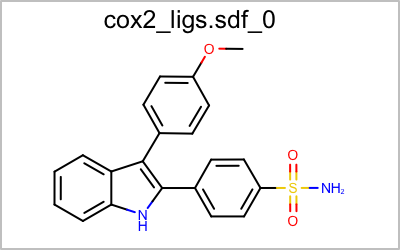
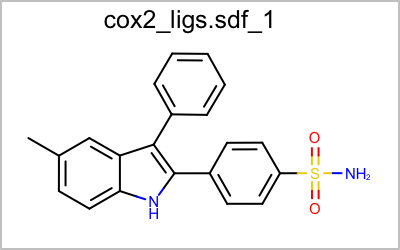

In [4]:
oenb.render_dataframe(df_2clus.head(2))

,Molecule,Title,Ki (nM),IC50 (nM),PubChem SID,Target
100,,40f,0.064,,49689000,Heat Shock Protein 90 (Hsp90)
101,,hsp90_ligs.sdf_1,0.2,,163350357,Heat Shock Protein 90 (Hsp90)

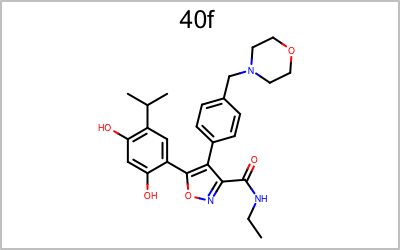
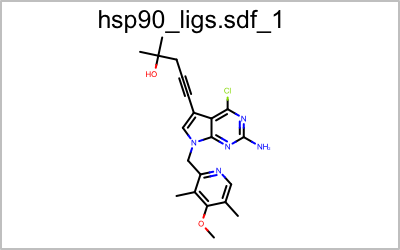

In [5]:
oenb.render_dataframe(df_2clus.iloc[100:102])

In [6]:
df_2clus['img'] = df_2clus.Molecule.apply(oenb.draw_mol_to_img_tag)
df_random['img'] = df_random.Molecule.apply(oenb.draw_mol_to_img_tag)

** Molecule Distances **

Now we need to calculate the distances between all the molecules in each dataset. We'll import a simple $n$-by-$n$ calculation object which uses [path fingerprint](http://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html#path) and converts to a distance.

In [7]:
from dist import CachingMolDistance, MolFPDist

In [8]:
rand_dists = CachingMolDistance(MolFPDist)
rand_dists.load(df_random.Molecule)


two_dists = CachingMolDistance(MolFPDist)
two_dists.load(df_2clus.Molecule)

In [9]:
# Split molecules for better plotting
cox_df = df_2clus[df_2clus.Target == "Cyclooxygenase-2"]
hsp_df = df_2clus[df_2clus.Target == "Heat Shock Protein 90 (Hsp90)"]

## Multidimensional Scaling

Multidimensional scaling attempts to find a representation in a lower dimensional space where distances between members are preserved from the high-dimensional space.

In [10]:
from sklearn.manifold import MDS

In [11]:
two_mds = MDS(dissimilarity="precomputed", max_iter=1000)
Y = two_mds.fit_transform(two_dists.DistArray)

rand_mds = MDS(dissimilarity="precomputed", max_iter=1000)
D = rand_mds.fit_transform(rand_dists.DistArray)

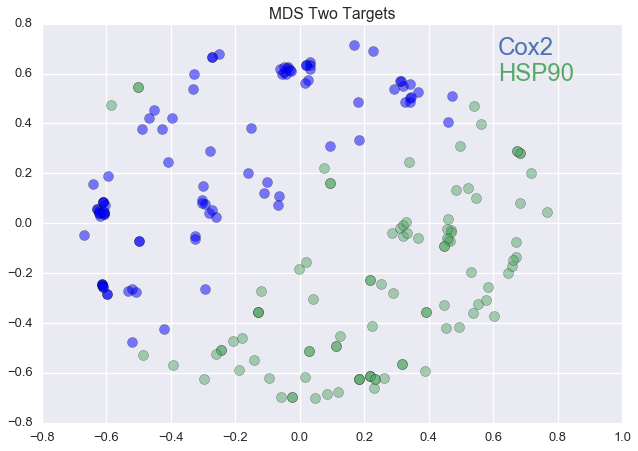

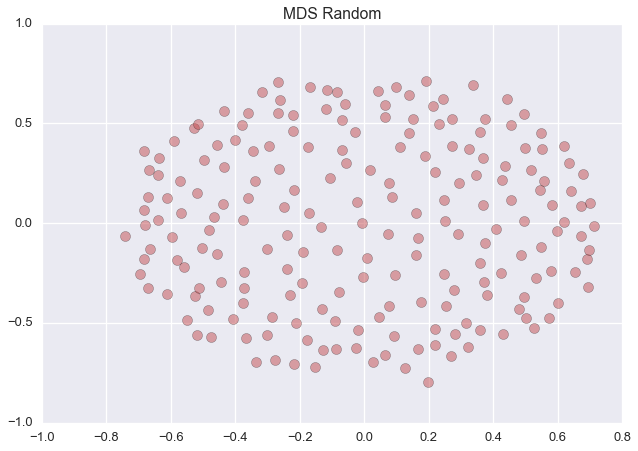

In [12]:
f = plt.figure()
sc = plt.scatter(Y[cox_df.index, 0], Y[cox_df.index, 1], s=100, alpha=0.5,label="Cox2")
sc2 = plt.scatter(Y[hsp_df.index, 0], Y[hsp_df.index, 1], c=colors[1], s=100, alpha=0.5,label="HSP90")

plt.title("MDS Two Targets")
plt.text(0.8*max(Y[:,0]),0.95*max(Y[:,1]),"Cox2",color=colors[0],size=24)
plt.text(0.8*max(Y[:,0]),0.8*max(Y[:,1]),"HSP90",color=colors[1],size=24)

if do_tooltips:
    oenb.add_molecule_tooltips(cox_df, sc, f, show=False, img_col="img")
    oenb.add_molecule_tooltips(hsp_df, sc2, f, img_col="img")
    f.clear()



f = plt.figure()
sc = plt.scatter(D[:,0], D[:,1], s=100, alpha=0.5, c=colors[2])
plt.title("MDS Random")
if do_tooltips:
    oenb.add_molecule_tooltips(df_random, sc, f, img_col="img")


### Non-metric MDS

Multidimensional scaling can also be performed without the assumption that this distances are a metric which satisfy the triangle inequality. The embedding attempts to preserve the order of the distances. 

In [13]:
two_nmds = MDS(dissimilarity="precomputed", max_iter=1000, metric=False)
Y = two_nmds.fit_transform(two_dists.DistArray)

rand_mds = MDS(dissimilarity="precomputed", max_iter=1000, metric=False)
D = rand_mds.fit_transform(rand_dists.DistArray)

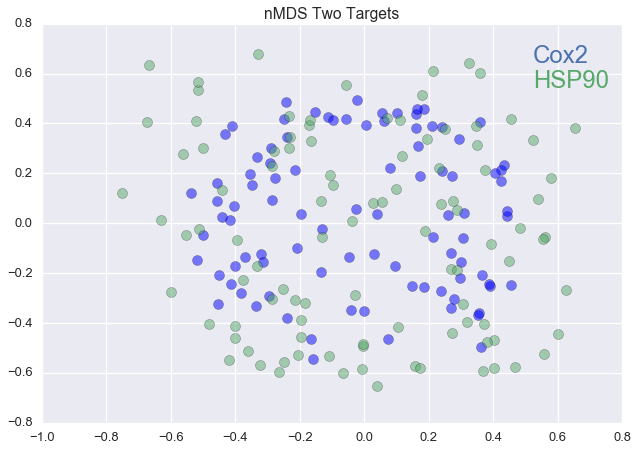

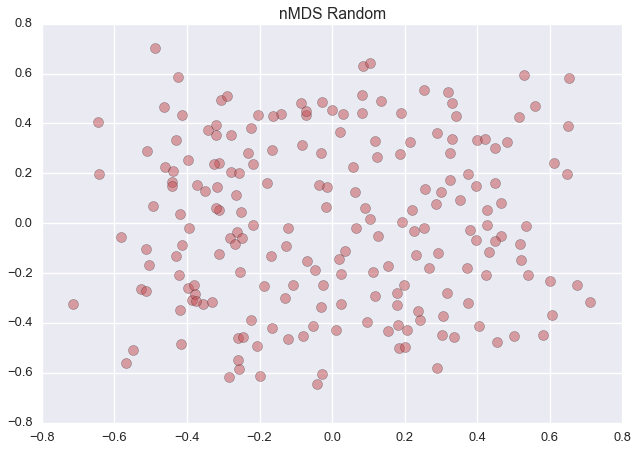

In [14]:
f = plt.figure()
sc = plt.scatter(Y[cox_df.index, 0], Y[cox_df.index, 1], s=100, alpha=0.5,label="Cox2")
sc2 = plt.scatter(Y[hsp_df.index, 0], Y[hsp_df.index, 1], c=colors[1], s=100, alpha=0.5,label="HSP90")

plt.title("nMDS Two Targets")
plt.text(0.8*max(Y[:,0]),0.95*max(Y[:,1]),"Cox2",color=colors[0],size=24)
plt.text(0.8*max(Y[:,0]),0.8*max(Y[:,1]),"HSP90",color=colors[1],size=24)

if do_tooltips:
    oenb.add_molecule_tooltips(cox_df, sc, f, show=False, img_col="img")
    oenb.add_molecule_tooltips(hsp_df, sc2, f, img_col="img")
    f.clear()

f = plt.figure()
sc = plt.scatter(D[:,0], D[:,1], s=100, alpha=0.5, c=colors[2])
plt.title("nMDS Random")
if do_tooltips:
    oenb.add_molecule_tooltips(df_random, sc, f, img_col="img")

## t-distributed Stochastic Neighbor Embedding

The **t-SNE** algorithm treats distances as joint gaussian distributions and minimizes the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the probabilities in the low-dimensional embedding and the original high-dimensional space.

In [15]:
from sklearn.manifold import TSNE

In [16]:
two_tsne = TSNE(metric="precomputed", learning_rate=150)
Y = two_tsne.fit_transform(two_dists.DistArray)

rand_tsne = TSNE(metric="precomputed", learning_rate=150)
D = rand_tsne.fit_transform(rand_dists.DistArray)

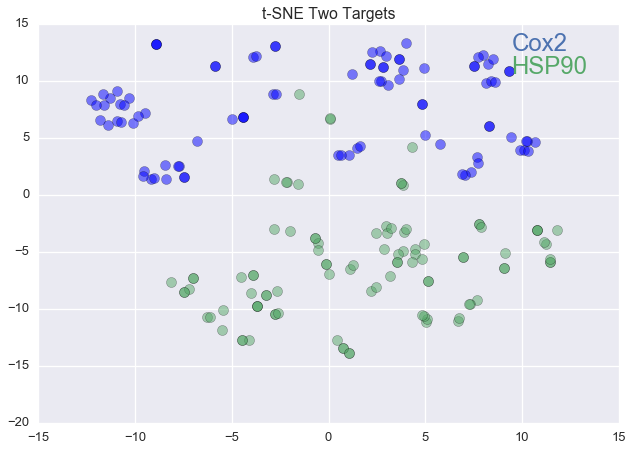

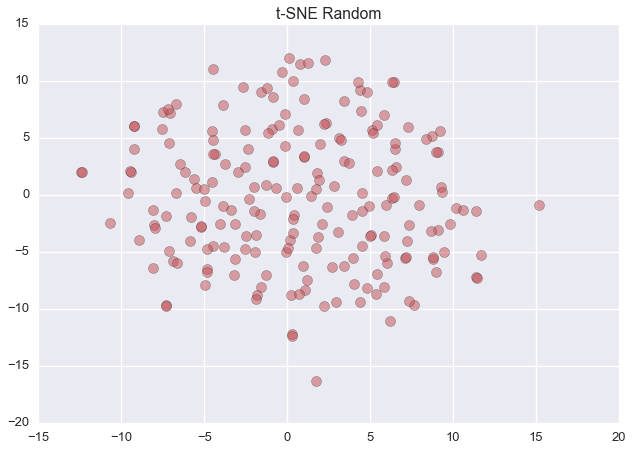

In [17]:
f = plt.figure()
sc = plt.scatter(Y[cox_df.index, 0], Y[cox_df.index, 1], s=100, alpha=0.5,label="Cox2")
sc2 = plt.scatter(Y[hsp_df.index, 0], Y[hsp_df.index, 1], c=colors[1], s=100, alpha=0.5,label="HSP90")

plt.title("t-SNE Two Targets")
plt.text(0.8*max(Y[:,0]),0.95*max(Y[:,1]),"Cox2",color=colors[0],size=24)
plt.text(0.8*max(Y[:,0]),0.8*max(Y[:,1]),"HSP90",color=colors[1],size=24)

if do_tooltips:
    oenb.add_molecule_tooltips(cox_df, sc, f, show=False, img_col="img")
    oenb.add_molecule_tooltips(hsp_df, sc2, f, img_col="img")
    f.clear()

f = plt.figure()
sc = plt.scatter(D[:,0], D[:,1], s=100, alpha=0.5, c=colors[2])
plt.title("t-SNE Random")
if do_tooltips:
    oenb.add_molecule_tooltips(df_random, sc, f, img_col="img")
    f.clear()

## Spectral Embedding

Spectral embedding finds a low-dimensional representation through spectral decomposition on the laplacian of the affinity graph.

In [18]:
from sklearn.manifold import SpectralEmbedding

In [19]:
se = SpectralEmbedding(affinity="precomputed")
Y = se.fit_transform(1.0 - two_dists.DistArray)

rand_se = SpectralEmbedding(affinity="precomputed")
D = rand_se.fit_transform(1.0 - rand_dists.DistArray)

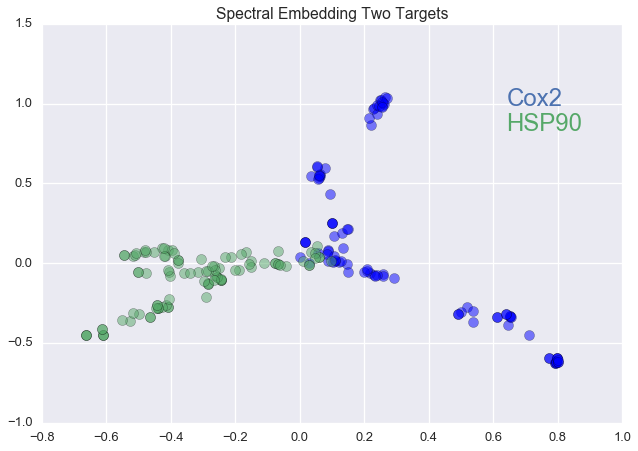

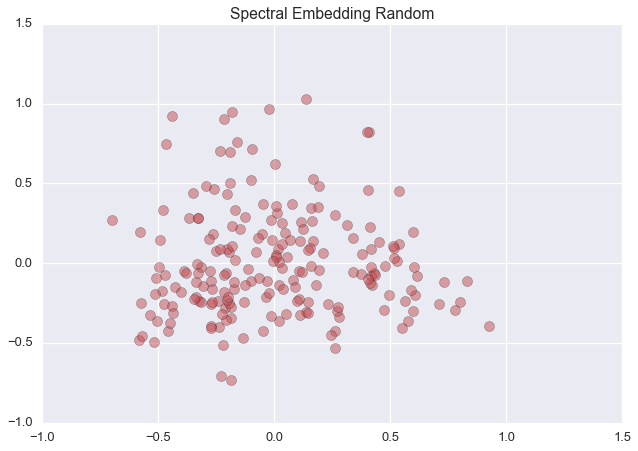

In [20]:
f = plt.figure()
sc = plt.scatter(Y[cox_df.index, 0], Y[cox_df.index, 1], s=100, alpha=0.5,label="Cox2")
sc2 = plt.scatter(Y[hsp_df.index, 0], Y[hsp_df.index, 1], c=colors[1], s=100, alpha=0.5,label="HSP90")
plt.text(0.8*max(Y[:,0]),0.95*max(Y[:,1]),"Cox2",color=colors[0],size=24)
plt.text(0.8*max(Y[:,0]),0.8*max(Y[:,1]),"HSP90",color=colors[1],size=24)

plt.title("Spectral Embedding Two Targets")

if do_tooltips:
    oenb.add_molecule_tooltips(cox_df, sc, f, show=False, img_col="img")
    oenb.add_molecule_tooltips(hsp_df, sc2, f, img_col="img")
    f.clear()

f = plt.figure()
sc = plt.scatter(D[:,0], D[:,1], s=100, alpha=0.5, c=colors[2])
plt.title("Spectral Embedding Random")
if do_tooltips:
    oenb.add_molecule_tooltips(df_random, sc, f, img_col="img")
    f.clear()